In [8]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import random
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
import seaborn as sns
import pickle
from pyspark.sql.functions import col, sum
import dataframe_image as dfi

sns.set(style="darkgrid")

# file_path = "/home/olek/studia/semestr_3_AM/Big_Data/Big_Data/projekt/data/charts.csv"
file_path = "/home/olek/studia/semestr_3_AM/Big_Data/Big_Data/projekt/data/sample.csv"

# results_path = "/home/olek/studia/semestr_3_AM/Big_Data/Big_Data/projekt/sample_results/"
if file_path.endswith("sample.csv"):
    results_path = "/home/olek/studia/semestr_3_AM/Big_Data/Big_Data/projekt/sample_results/"
    images_path = "/home/olek/studia/semestr_3_AM/Big_Data/Big_Data/projekt/sample_images/"
else:
    results_path = "/home/olek/studia/semestr_3_AM/Big_Data/Big_Data/projekt/results/"
    images_path = "/home/olek/studia/semestr_3_AM/Big_Data/Big_Data/projekt/images/"

seed = 777
np.random.seed(seed)
random.seed(seed)

In [78]:
# pd.read_csv("/home/olek/studia/semestr_3_AM/Big_Data/Big_Data/projekt/data/charts.csv", nrows=10**6)\
#     .to_csv("/home/olek/studia/semestr_3_AM/Big_Data/Big_Data/projekt/data/sample.csv", index=False)

In [2]:
spark = SparkSession.builder \
    .appName("Read CSV File") \
    .getOrCreate()
df = spark.read.csv(file_path, header=True, inferSchema=True)
df = df.withColumn("rank", f.col("rank").cast(t.IntegerType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))
df.registerTempTable("charts")

24/06/24 14:38:28 WARN Utils: Your hostname, olek resolves to a loopback address: 127.0.1.1; using 192.168.100.7 instead (on interface wlp6s0)
24/06/24 14:38:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/24 14:38:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/24 14:38:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/home/olek/.local/lib/python3.10/site-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [4]:
df.printSchema()

root
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: integer (nullable = true)



In [3]:
spark.sql('''
SELECT COUNT(*) as count
FROM charts ;
''').toPandas().head(10)

,count
0,1000000


# Show head data:

In [15]:
%time
head = spark.sql("SELECT * FROM charts LIMIT 10")
with open(results_path + "head.pkl", "wb") as f:
    pickle.dump(head.toPandas(), f)
    
df_styled = spark.sql("SELECT * from charts limit 10").toPandas().style.background_gradient() 
dfi.export(df_styled, images_path + "mytable.png")
df_styled = head.toPandas().style.background_gradient() 
dfi.export(df_styled, images_path + "head.png")
head.toPandas()

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.4 µs


# EDA

## Missing data

In [8]:
%time
columns = df.columns
missing_data = df.select([(sum(col(c).isNull().cast("int")).alias(c)) for c in columns])
missing_data.show()

with open(results_path + "missing_data.pkl", "wb") as f:
    pickle.dump(missing_data.toPandas(), f)

df_styled = missing_data.toPandas().style.background_gradient()
dfi.export(df_styled, images_path + "missing_data.png")

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 16.7 µs


+-----+----+----+------+---+------+-----+-----+-------+
|title|rank|date|artist|url|region|chart|trend|streams|
+-----+----+----+------+---+------+-----+-----+-------+
|    0|  23|  23|     0|  0|     0|    0|    0| 166774|
+-----+----+----+------+---+------+-----+-----+-------+



## unique_values

In [9]:
%time
missing_streams_df = df.filter(col('streams').isNull())
unique_values = {col_name: missing_streams_df.select(col_name).distinct().count() for col_name in missing_streams_df.columns}
unique_values_df = pd.DataFrame(unique_values, index=[0])

with open(results_path + "unique_values_df.pkl", "wb") as f:
    pickle.dump(unique_values_df, f)

df_styled = unique_values_df.style.background_gradient() 
dfi.export(df_styled, images_path + "unique_values.png")

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 18.1 µs


## Count np of missing striming value per chart

In [128]:
%time
null_cart = spark.sql("""
    SELECT chart, count(chart) as count
    FROM charts
    WHERE streams IS NULL
    GROUP BY chart
    ORDER BY count DESC;""")
null_cart_df = null_cart.toPandas()
with open(results_path + "null_cart_df.pkl", "wb") as f:
    pickle.dump(null_cart_df, f)

df_styled = null_cart_df.style.background_gradient() 
dfi.export(df_styled, images_path + "unique_values.png")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


## SElect TOP200 

In [12]:
%time
filtered_df = spark.sql("SELECT * FROM charts WHERE chart = 'top200'")
filtered_df.show()
df = filtered_df
df.createOrReplaceTempView("charts")

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 15.7 µs


+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|               title|rank|      date|              artist|                 url|   region| chart|        trend|streams|
+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|Chantaje (feat. M...|   1|2017-01-01|             Shakira|https://open.spot...|Argentina|top200|SAME_POSITION| 253019|
|Vente Pa' Ca (fea...|   2|2017-01-01|        Ricky Martin|https://open.spot...|Argentina|top200|      MOVE_UP| 223988|
|Reggaetón Lento (...|   3|2017-01-01|                CNCO|https://open.spot...|Argentina|top200|    MOVE_DOWN| 210943|
|              Safari|   4|2017-01-01|J Balvin, Pharrel...|https://open.spot...|Argentina|top200|SAME_POSITION| 173865|
|         Shaky Shaky|   5|2017-01-01|        Daddy Yankee|https://open.spot...|Argentina|top200|      MOVE_UP| 153956|
|         Traicionera|   6|2017-01-01|  

In [14]:
%time
columns = df.columns
missing_data = df.select([(sum(col(c).isNull().cast("int")).alias(c)) for c in columns])
missing_data.show()

with open(results_path + "missing_data_clearing.pkl", "wb") as f:
    pickle.dump(missing_data.toPandas(), f)

df_styled = missing_data.toPandas().style.background_gradient()
dfi.export(df_styled, images_path + "missing_data.png")

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 15.7 µs


+-----+----+----+------+---+------+-----+-----+-------+
|title|rank|date|artist|url|region|chart|trend|streams|
+-----+----+----+------+---+------+-----+-----+-------+
|    0|   0|   0|     0|  0|     0|    0|    0|      0|
+-----+----+----+------+---+------+-----+-----+-------+



In [5]:
%time
data_intervale = spark.sql("SELECT  MAX(date), MIN(date), MAX(date) - MIN(date) as intervale FROM charts")
data_intervale.show()
full_data = data_intervale.toPandas()["intervale"][0].days

with open(results_path + "data_intervale.pkl", "wb") as f:
    pickle.dump(data_intervale.toPandas(), f)

df_styled = data_intervale.toPandas()
df_styled["intervale"] = full_data
df_styled.style.background_gradient()
dfi.export(df_styled, images_path + "data_intervale.png")
df_styled

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 14.3 µs


+----------+----------+-------------------+
| max(date)| min(date)|          intervale|
+----------+----------+-------------------+
|2021-10-15|2017-01-01|INTERVAL '1748' DAY|
+----------+----------+-------------------+



,max(date),min(date),intervale
0,2021-10-15,2017-01-01,1748


# EDA after clean

In [10]:
spark = SparkSession.builder \
    .appName("Read CSV File") \
    .getOrCreate()
file_path = "/home/olek/studia/semestr_3_AM/Big_Data/Big_Data/projekt/data/sample_3.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)
df = df.withColumn("rank", f.col("rank").cast(t.IntegerType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))
df.registerTempTable("charts")

## integrity ratio by region

In [12]:
procentag_region = spark.sql("""
    SELECT region, COUNT(region) as count, COUNT(region) / {} as procent
    FROM charts
    GROUP BY region
    ORDER BY count DESC;""".format(full_data*200))
procentag_region = procentag_region.toPandas()

with open(results_path + "procentag_region.pkl", "wb") as f:
    pickle.dump(procentag_region, f)

procentag_region_filtr = pd.concat([procentag_region.head(5), procentag_region[procentag_region["region"] == "Poland"] , procentag_region.tail(5)])
df_styled = procentag_region_filtr.style.background_gradient()
dfi.export(df_styled, images_path + "procentag_region.png")
df_styled

,region,count,procent
0,Brazil,1934,0.005532
1,Austria,1934,0.005532
2,United States,1870,0.005349
3,Philippines,1863,0.005329
4,Indonesia,1857,0.005312
32,Poland,1764,0.005046
70,Zion & Lennox,2,0.000006
71,Ozuna,2,0.000006
72,https://open.spotify.com/track/1Fp4njyRHJYyMTKP899c0q,1,0.000003
73,Nino Freestyle,1,0.000003


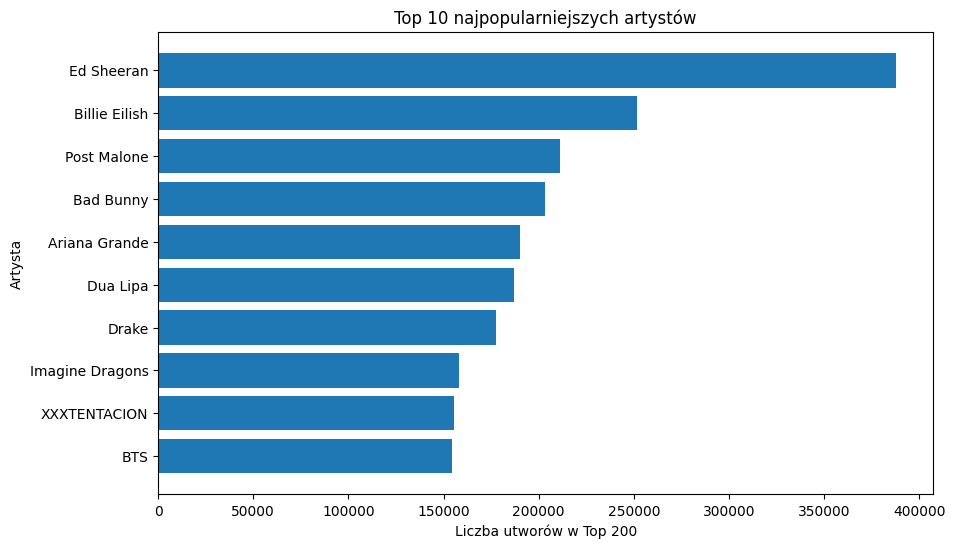

In [25]:
from pyspark.sql.functions import col, count

artist_counts = df.groupBy('artist').agg(count('title').alias('song_count')).orderBy(col('song_count').desc())

# Konwersja do Pandas DataFrame dla łatwiejszej wizualizacji
artist_counts_pd = artist_counts.limit(10).toPandas()

# Wykres słupkowy najpopularniejszych artystów
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(artist_counts_pd['artist'], artist_counts_pd['song_count'])
plt.title('Top 10 najpopularniejszych artystów')
plt.xlabel('Liczba utworów w Top 200')
plt.ylabel('Artysta')
plt.gca().invert_yaxis()
plt.show()

In [13]:
spark.sql('''
SELECT * 
FROM charts 
WHERE chart = 'top200' 
LIMIT 10;
''').toPandas()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012


In [22]:
spark.sql("""
    SELECT chart, COUNT(*) count
    FROM charts
    GROUP BY chart
    ORDER BY count DESC
    ;""").show()

+--------------------+--------+
|               chart|   count|
+--------------------+--------+
|              top200|20318183|
|             viral50| 5848001|
|            Paraguay|     704|
|             Germany|     555|
|               Chile|     516|
|https://open.spot...|     438|
|https://open.spot...|     259|
|               Spain|     231|
|       United States|     214|
|             Austria|     206|
|              Canada|     187|
|https://open.spot...|     176|
|             Uruguay|     170|
|         Switzerland|     159|
|https://open.spot...|     147|
|             Ireland|     145|
|  Dominican Republic|     141|
|           Argentina|     121|
|                Peru|     120|
|https://open.spot...|     118|
+--------------------+--------+
only showing top 20 rows



In [18]:
spark.sql('''
SELECT COUNT(*) NoOfObservationsTop200
FROM charts 
WHERE chart = 'top200';
''').toPandas().head(10)

,NoOfObservationsTop200
0,20318183
